In [1]:
import funconnect

Connecting celiib@10.28.0.34:3306


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import datajoint as dj
from funconnect import connectomics as cncs, ta3, nda
from funconnect.connectomics import *
from funconnect import nda
import numpy as np
import pandas as pd
import pycircstat as circ
cncs.schema.spawn_missing_classes()

In [4]:
#how they generate the SharedInput
soma = ta3.Segment & nda.Trace
axons = ta3.Neurite & 'neurite_type="axon"'
synapse = ta3.Synapse & axons.proj(presyn='segment_id')
info = soma * soma.proj(segment_b='segment_id') & 'segment_id > segment_b'
A = (synapse & soma.proj(postsyn='segment_id')).proj(
    'presyn', syn1='synapse_id', segment_id='postsyn')
B = (synapse * dj.U('presyn') & soma.proj(postsyn='segment_id')).proj(
    'presyn', syn2='synapse_id', segment_b='postsyn')
shared = dj.U('segment_id', 'segment_b').aggr(A * B & 'segment_id > segment_b',
                                              n_seg_shared='count(DISTINCT presyn)')
shared

attrs = ['segment_a', 'segment_b', 'n_seg_shared']
shared_new = dj.U(*attrs) & shared.proj('n_seg_shared', segment_a = 'segment_id')
len(shared_new)*2*3

128826

# Orientation tuning

Set some parameters for the analysis

In [5]:
#sets up the graphing variables for below
is_tuned = 'von_r2>0.05 and von_pvalue<0.05'
dori_resolution = np.pi / 2 / 4
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9)
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in bin_edges]])
bin_labels = list(zip(be[:-1], be[1:]))
bin_centers = np.round((bin_edges[1:] + bin_edges[:-1])/2 * rad2deg, decimals=2) 

Massage the relations

In [6]:
tuned_rel = nda.VonMises() & is_tuned
best_r2 = dj.U('segment_id').aggr(tuned_rel, best_r2='max(von_r2)')
pref_rel = (tuned_rel * best_r2) & 'von_r2 >= best_r2'
pref_rel

#contains all of the tuning data for the neuron segments 

scan_idx scan ID,segmentation segmentation id,segment_id segment id unique within each Segmentation,von_r2 r-squared explaned by vonMises fit,von_pref preferred directions,von_base von mises base value,von_amp1 amplitude of first peak,von_amp2 amplitude of second peak,von_sharp sharpnesses,von_pvalue p-value by shuffling (nShuffles = 1e4),best_r2 calculated attribute
2,1,2589588,0.053372,3.02107,0.00165716,0.0787312,0.0374586,26.5923,0.006497,0.053372
2,1,3813916,0.0578909,2.90859,0.017539,0.139912,0.0,16.2428,0.0014995,0.0578909
2,1,10914339,0.0799213,3.13328,0.0113467,0.297867,0.169138,11.2455,0.002499,0.0799213
2,1,16809519,0.236849,4.00482,0.00729216,0.537001,0.32923,19.5817,0.0005,0.236849
2,1,23410728,0.118081,2.10778,0.0550229,1.0047,0.292185,5.85615,0.0005,0.118081
2,1,27229091,0.161084,5.57486,0.00616441,0.450609,0.0902593,14.4957,0.0005,0.161084
2,1,38469670,0.198155,5.51238,0.00350638,0.232938,0.0834227,37.8783,0.0005,0.198155


In [7]:
p_cond = dict(p='n_seg_shared > 0')
# p_cond = dict(p='n_seg_shared = 10')
attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
example_table = dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')


In [8]:
#stacks them on top of each other
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id'))

shi

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments
694582,all,421208,16
694582,non-perisomatic,421208,16
694582,perisomatic,421208,0
845222,all,421208,0
845222,all,694582,0
845222,non-perisomatic,421208,0
845222,non-perisomatic,694582,0


In [9]:
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id')) #+ \
#       (dj.U(*attrs) & SharedContactPair.proj('segment_a', 'segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) + \
#       (dj.U(*attrs) & SharedContactPair.proj(segment_b='segment_a', segment_a='segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) 

#restricts and appends the orientation
rel2 = shi  * pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref')

'''description of the output
1) segments a and b that are connected
2) type of connection
3) number of shared segments between them
4) orinetations of both of the segments


'''
rel2

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments,dummy scan ID,segmentation segmentation id,scan_idx scan ID,ori_1 preferred directions,ori_2 preferred directions
2589588,non-perisomatic,55282126,3,2,1,2,3.02107,4.01177
2589588,all,96470806,0,2,1,2,3.02107,3.31179
2589588,non-perisomatic,72259575,1,2,1,3,3.02107,0.664596
2589588,all,23410728,13,2,1,2,3.02107,2.10778
2589588,perisomatic,81578447,0,2,1,2,3.02107,3.27333
2589588,perisomatic,65407842,0,2,1,3,3.02107,4.75491
2589588,perisomatic,10356289,0,2,1,6,3.02107,3.17413


Fetch the dataframe and bin the orientations

In [10]:
df=pd.read_pickle("shared_connections.pkl")
print(len(df))
df

4550


,segment_a,connection,segment_b,n_seg_shared,dummy,segmentation,scan_idx,ori_1,ori_2
0,83286327,apical (>0.75),46354569,0,2,1,2,5.463940,3.851180
1,83286327,apical (>0.75),10356289,0,2,1,2,5.463940,3.174130
2,83286327,apical (>0.75),39500491,0,2,1,2,5.463940,3.106100
3,83286327,apical (>0.75),942272,0,2,1,2,5.463940,5.087230
4,83286327,apical (>0.75),23683777,0,2,1,2,5.463940,2.921270
5,83286327,apical (>0.75),78665518,0,2,1,2,5.463940,2.973850
6,83286327,apical (>0.75),94050687,0,2,1,2,5.463940,2.239210
7,83286327,apical (>0.75),107731759,0,2,1,2,5.463940,4.128270
8,83286327,apical (>0.75),67981253,0,2,1,2,5.463940,4.891510
9,83286327,apical (>0.75),107860456,0,2,1,2,5.463940,3.164700


In [11]:
#puts the restricted table into a dataframe (no more datajoint from here to graph)   ####Error fixed here
#df = pd.DataFrame(rel2.fetch())



df['dori'] = np.abs(circ.cdiff(2 * df['ori_1'], 2 * df['ori_2'])/2)
df['bdori'] = bin_centers[(np.digitize(np.abs(circ.cdiff(2 * df['ori_1'], 2 * df['ori_2'])/2), bin_edges))-1]

df['ori_1'] = (df['ori_1'] % np.pi) * rad2deg
df['ori_2'] = (df['ori_2'] % np.pi) * rad2deg

df['bori_1'] = bin_centers[(np.digitize(df['ori_1']/rad2deg % np.pi, bin_edges))-1]
df['bori_2'] = bin_centers[(np.digitize(df['ori_2']/rad2deg % np.pi, bin_edges))-1]


# Plot cumulative distributions

In [12]:
stuff = ['connection', 'bdori', 'n_seg_shared']

n = df.groupby(stuff)['dummy'].count().reset_index()
s = n.groupby(stuff[:-1]).transform('sum')
cs = n.groupby(stuff[:-1]).transform('cumsum')
n['P'] = 1 - cs['dummy']/s['dummy']
n['csum'] = cs['dummy']
n['sum'] = s['dummy']
n['prob'] = n['dummy']/s['dummy']
#n

## P(more than k shared segments| $\Delta \vartheta$)

In [13]:
# #still plotting the figures
# n['k'] = n['n_seg_shared']
# sns.set_context('notebook', font_scale=1.3)
# g = sns.catplot('bdori', 'P', data=n, kind='point', col='connection', hue='k', hue_order=np.arange(12), 
#                 palette=sns.color_palette("GnBu_d", n_colors=12), legend=False, legend_out=True, sharey=False)
# g.set_titles('{col_name} axons')
# g.set_axis_labels(y_var='p(number of shared segments>k)', x_var=r'$\Delta \theta$')
# for ax in g.axes.ravel():
#     ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
# # g.axes[0,-1].legend(title='k', ncol=3)
# g.add_legend(title='k', ncol=2)

# sns.despine(trim=True)
# g.fig.subplots_adjust(bottom=.2)
# g.fig.savefig('figures/shared_input_cumprob.png', dpi=200)
# g.fig.savefig('figures/shared_input_cumprob.pdf')

# $\langle$ shared segments $\rangle$ as function of $\Delta \theta$

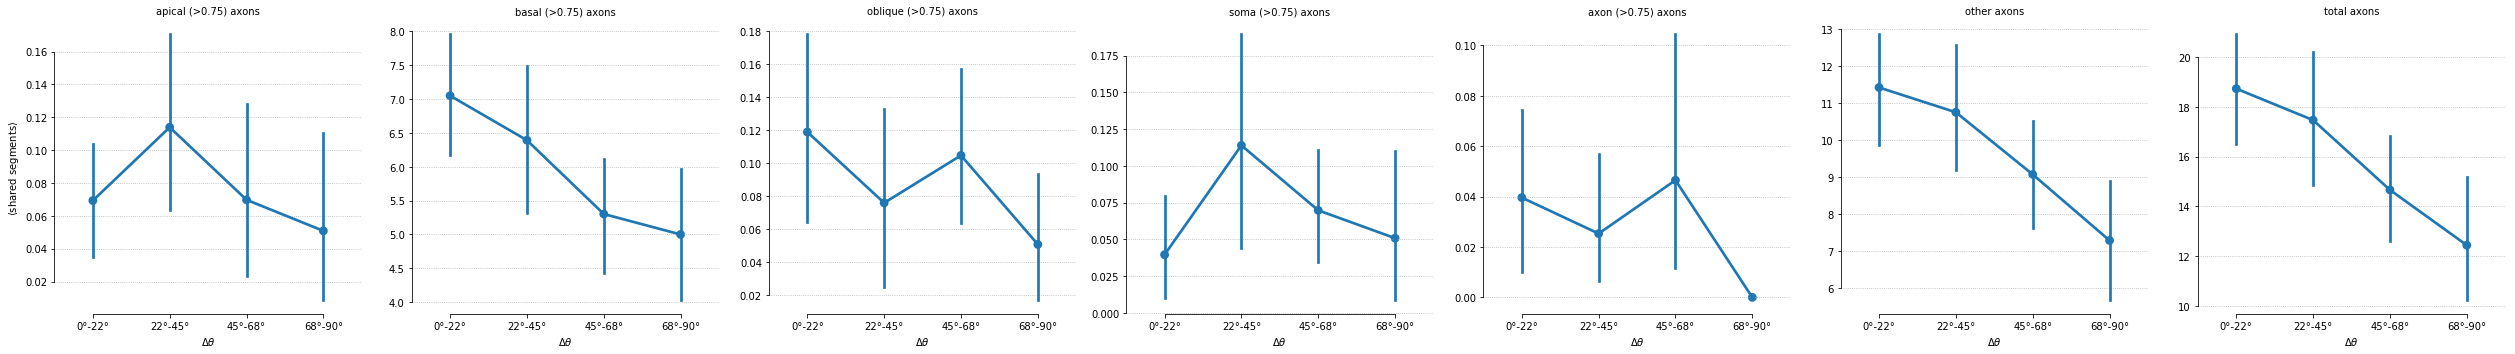

In [14]:
g = sns.catplot('bdori', 'n_seg_shared', data=df, kind='point', col='connection',  legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared segments$\rangle$')
# g.ax.set_yticks(np.arange(2,7))
# g.ax.yaxis.grid(True, linestyle=':')
for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
sns.despine(trim=True)
g.set_titles('{col_name} axons')
# g.ax.set_title('non-perisomatic axons')
g.fig.savefig('figures/average_shared_input.png', dpi=200)
g.fig.savefig('figures/average_shared_input.pdf')

# ------------apical Combined plot------------------------------

Get input density per postsynaptic neuron

In [15]:
compartment_axons = np.load("compartment_axon_groups.npz")
apical_axons = compartment_axons["apical_axons"]

In [16]:
######-------------COULD JUST RESTRICT BY THE SYNAPSE NUMBER HERE ------------############



dict_key = [dict(presyn=c) for c in apical_axons]
segs = (ta3.Synapse * pref_rel.proj(ori='von_pref', postsyn='segment_id') 
            & (ta3.Neurite & dict(neurite_type='axon')).proj(presyn='segment_id') & dict_key)
                
''' output: on a synapse level here


'''

segs

segmentation segmentation id,synapse_id synapse index within the segmentation,scan_idx scan ID,postsyn segment id unique within each Segmentation,presyn segment id unique within each Segmentation,synapse_x (EM voxels),synapse_y (EM voxels),synapse_z (EM voxels),syn_bbox_x1 (EM voxels) - bounding box,syn_bbox_y1 (EM voxels) - bounding box,syn_bbox_z1 (EM voxels) - bounding box,syn_bbox_x2 (EM voxels) - bounding box,syn_bbox_y2 (EM voxels) - bounding box,syn_bbox_z2 (EM voxels) - bounding box,ori preferred directions
1,2261692,2,3813916,65442634,57659,23922,585,57636,23891,583,57689,23952,587,2.90859
1,2002180,2,10914339,41829041,52560,16168,450,52521,16141,447,52602,16197,453,3.13328
1,2002428,2,10914339,41829041,52769,16951,419,52714,16887,414,52811,17015,426,3.13328
1,2003440,2,10914339,41829041,52806,17319,363,52759,17206,360,52873,17406,371,3.13328
1,2004337,2,10914339,41829041,52749,18118,360,52706,18037,358,52781,18167,362,3.13328
1,2004377,2,10914339,41829041,52765,18470,331,52746,18445,329,52788,18496,333,3.13328
1,2070805,2,10914339,95551430,54231,32340,543,54208,32325,541,54260,32355,546,3.13328


In [17]:
#gets the segments and their orientation preference

df_segments = pd.DataFrame(segs.fetch())
df_segments['ori'] = (df_segments['ori'] % np.pi) * rad2deg
df_segments['bori'] = bin_centers[(np.digitize(df_segments['ori'] % np.pi, bin_edges))-1]
df_m = df_segments.groupby(['postsyn','ori','bori'])['presyn'].count().reset_index()

Get tuned neurons

In [18]:
df_tuned = pd.DataFrame(pref_rel.proj(ori='von_pref').fetch())
df_tuned['ori'] = (df_tuned['ori'] % np.pi) * rad2deg

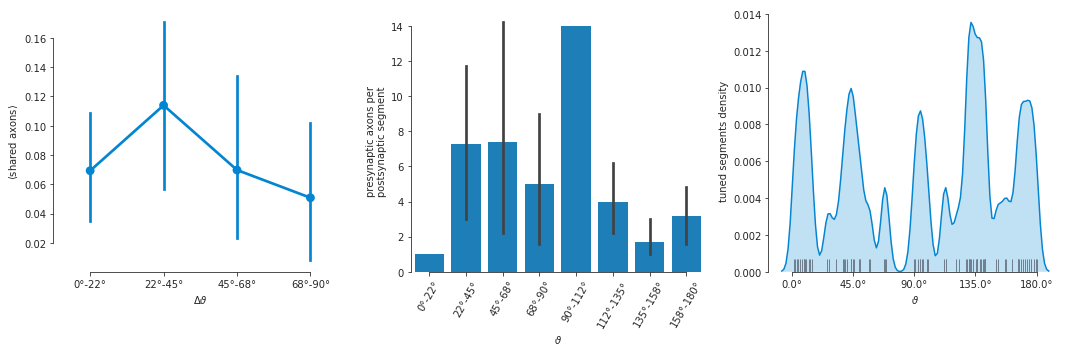

In [19]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
blue = sns.xkcd_rgb['cerulean']
sns.pointplot('bdori', 'n_seg_shared', data=df[df.connection == "apical (>0.75)"], kind='point', ax=ax[0], color=blue)
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)

# sns.distplot(df_segments.ori, ax=ax[1], kde=False, norm_hist=False,
#             hist_kws=dict(color=blue))
sns.barplot('bori', 'presyn', ax=ax[1], data=df_m, orient='vertical', color=blue)

sns.distplot(df_tuned.ori, ax=ax[2], kde=True, rug=True, 
             kde_kws=dict(bw=3, shade=True, color=blue), 
             rug_kws=dict(color='slategray'),
             hist=False)


ax[0].set_ylabel(r'$\langle$shared axons$\rangle$')
ax[0].set_xlabel(r'$\Delta \vartheta$')

xt = np.linspace(0, 180, 5)
for a in ax[1:]:
    a.set_xlabel(r'$\vartheta$')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=60)

ax[2].set_xticks(xt)
ax[2].set_xticklabels(['{}°'.format(t) for t in xt])
ax[1].set_ylabel('presynaptic axons per\npostsynaptic segment')
ax[2].set_ylabel('tuned segments density')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/tuning_statistics.png', dpi=200)
fig.savefig('figures/tuning_statistics.pdf')                    ######polar plot to do

# APICAL Heatmap of preferred orientation and number of shared segments

bori_2,33.75,56.25,78.75,101.25,123.75,146.25,168.75
bori_1,,,,,,,
33.75,0.3,0.00,0.2000,0.300,0.1000,0.000,0.1000
56.25,0.0,0.10,0.0000,0.000,0.0500,0.000,0.0500
78.75,0.2,0.00,0.0000,0.375,0.0000,0.000,0.0625
101.25,0.3,0.00,0.3750,0.000,0.0000,0.000,0.0000
123.75,0.1,0.05,0.0000,0.000,0.0000,0.125,0.1875
146.25,0.0,0.00,0.0000,0.000,0.1250,0.000,0.0000
168.75,0.1,0.05,0.0625,0.000,0.1875,0.000,0.0000


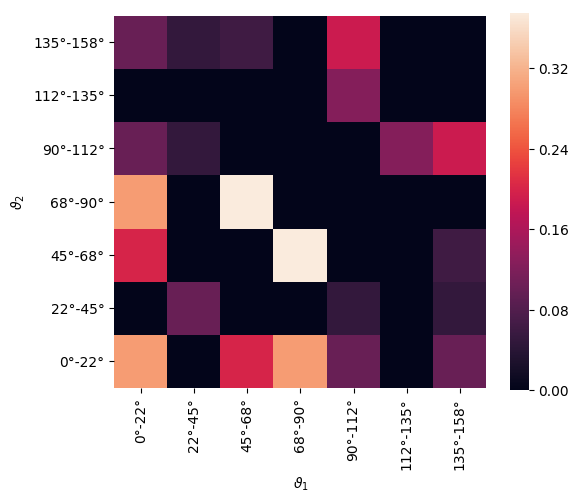

In [20]:
df2 = df[df.connection == 'apical (>0.75)'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)
g.figure.set_size_inches((6,5))
g.figure.set_dpi(100)
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.invert_yaxis()
g.set_xlabel(r'$\vartheta_1$')
g.set_ylabel(r'$\vartheta_2$')
df2

# ------------Basal Combined plot------------------------------#

In [21]:
compartment_axons = np.load("compartment_axon_groups.npz")
basal_axons = compartment_axons["basal_axons"]

In [22]:
######-------------COULD JUST RESTRICT BY THE SYNAPSE NUMBER HERE ------------############



dict_key = [dict(presyn=c) for c in basal_axons]
segs = (ta3.Synapse * pref_rel.proj(ori='von_pref', postsyn='segment_id') 
            & (ta3.Neurite & dict(neurite_type='axon')).proj(presyn='segment_id') & dict_key)
                
''' output: on a synapse level here


'''

segs

segmentation segmentation id,synapse_id synapse index within the segmentation,scan_idx scan ID,postsyn segment id unique within each Segmentation,presyn segment id unique within each Segmentation,synapse_x (EM voxels),synapse_y (EM voxels),synapse_z (EM voxels),syn_bbox_x1 (EM voxels) - bounding box,syn_bbox_y1 (EM voxels) - bounding box,syn_bbox_z1 (EM voxels) - bounding box,syn_bbox_x2 (EM voxels) - bounding box,syn_bbox_y2 (EM voxels) - bounding box,syn_bbox_z2 (EM voxels) - bounding box,ori preferred directions
1,1311167,2,2589588,112946815,37753,39107,203,37720,39066,200,37786,39159,207,3.02107
1,1355426,2,2589588,89938959,38123,38546,152,38092,38523,151,38152,38568,154,3.02107
1,1357808,2,2589588,109019111,38186,40798,243,38171,40770,240,38202,40826,247,3.02107
1,1386342,2,2589588,60319454,39947,24028,284,39910,23999,282,39986,24052,287,3.02107
1,1396009,2,2589588,90642500,39824,31039,246,39811,31024,243,39838,31054,248,3.02107
1,1397677,2,2589588,94332402,39401,32404,93,39346,32377,88,39469,32435,100,3.02107
1,1397920,2,2589588,86646371,39629,33062,47,39583,33033,46,39659,33092,49,3.02107


In [23]:
#gets the segments and their orientation preference

df_segments = pd.DataFrame(segs.fetch())
df_segments['ori'] = (df_segments['ori'] % np.pi) * rad2deg
df_segments['bori'] = bin_centers[(np.digitize(df_segments['ori'] % np.pi, bin_edges))-1]
df_m = df_segments.groupby(['postsyn','ori','bori'])['presyn'].count().reset_index()

Get tuned neurons

In [24]:
df_tuned = pd.DataFrame(pref_rel.proj(ori='von_pref').fetch())
df_tuned['ori'] = (df_tuned['ori'] % np.pi) * rad2deg

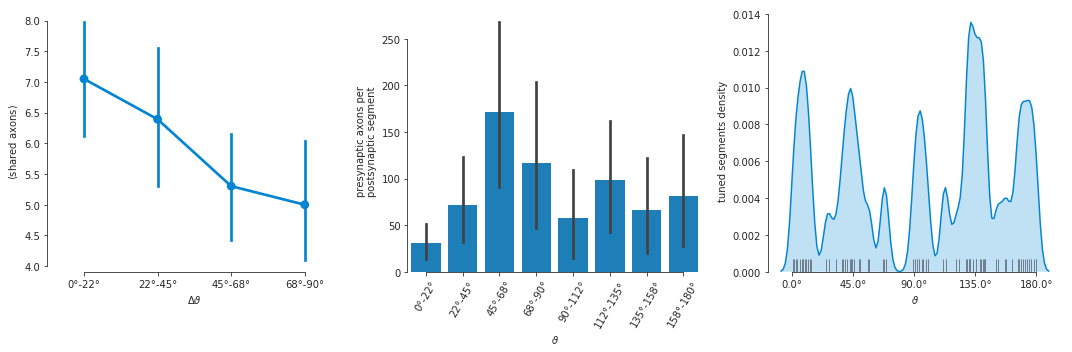

In [25]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
blue = sns.xkcd_rgb['cerulean']                     #####changed only to this connection
sns.pointplot('bdori', 'n_seg_shared', data=df[df.connection == "basal (>0.75)"], kind='point', ax=ax[0], color=blue)
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)

# sns.distplot(df_segments.ori, ax=ax[1], kde=False, norm_hist=False,
#             hist_kws=dict(color=blue))
sns.barplot('bori', 'presyn', ax=ax[1], data=df_m, orient='vertical', color=blue)

sns.distplot(df_tuned.ori, ax=ax[2], kde=True, rug=True, 
             kde_kws=dict(bw=3, shade=True, color=blue), 
             rug_kws=dict(color='slategray'),
             hist=False)


ax[0].set_ylabel(r'$\langle$shared axons$\rangle$')
ax[0].set_xlabel(r'$\Delta \vartheta$')

xt = np.linspace(0, 180, 5)
for a in ax[1:]:
    a.set_xlabel(r'$\vartheta$')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=60)

ax[2].set_xticks(xt)
ax[2].set_xticklabels(['{}°'.format(t) for t in xt])
ax[1].set_ylabel('presynaptic axons per\npostsynaptic segment')
ax[2].set_ylabel('tuned segments density')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/tuning_statistics.png', dpi=200)
fig.savefig('figures/tuning_statistics.pdf')

# BASALHeatmap of preferred orientation and number of shared segments

bori_2,33.75,56.25,78.75,101.25,123.75,146.25,168.75
bori_1,,,,,,,
33.75,3.00,6.12,5.250000,3.900,4.750000,5.800,5.250
56.25,6.12,6.80,7.700000,4.600,7.250000,8.700,8.000
78.75,5.25,7.70,6.666667,2.375,7.250000,8.750,7.375
101.25,3.90,4.60,2.375000,2.000,5.375000,3.500,2.750
123.75,4.75,7.25,7.250000,5.375,4.833333,7.500,5.500
146.25,5.80,8.70,8.750000,3.500,7.500000,5.000,7.625
168.75,5.25,8.00,7.375000,2.750,5.500000,7.625,6.000


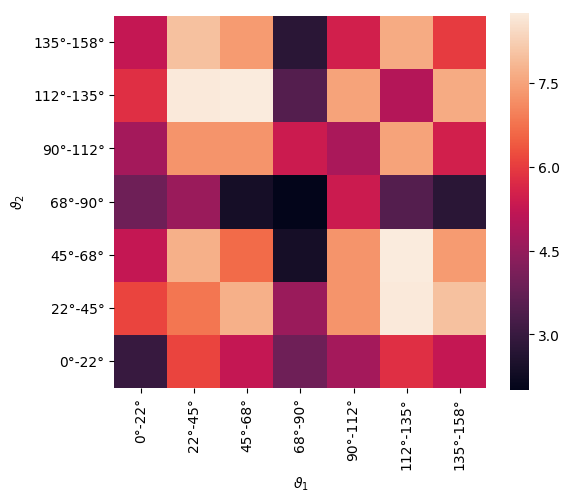

In [26]:
df2 = df[df.connection == 'basal (>0.75)'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)
g.figure.set_size_inches((6,5))
g.figure.set_dpi(100)
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.invert_yaxis()
g.set_xlabel(r'$\vartheta_1$')
g.set_ylabel(r'$\vartheta_2$')
df2

# ------------ObliqueCombined plot------------------------#

In [27]:
compartment_axons = np.load("compartment_axon_groups.npz")
oblique_axons = compartment_axons["oblique_axons"]

In [28]:
######-------------COULD JUST RESTRICT BY THE SYNAPSE NUMBER HERE ------------############



dict_key = [dict(presyn=c) for c in oblique_axons]
segs = (ta3.Synapse * pref_rel.proj(ori='von_pref', postsyn='segment_id') 
            & (ta3.Neurite & dict(neurite_type='axon')).proj(presyn='segment_id') & dict_key)
                
''' output: on a synapse level here


'''

segs

segmentation segmentation id,synapse_id synapse index within the segmentation,scan_idx scan ID,postsyn segment id unique within each Segmentation,presyn segment id unique within each Segmentation,synapse_x (EM voxels),synapse_y (EM voxels),synapse_z (EM voxels),syn_bbox_x1 (EM voxels) - bounding box,syn_bbox_y1 (EM voxels) - bounding box,syn_bbox_z1 (EM voxels) - bounding box,syn_bbox_x2 (EM voxels) - bounding box,syn_bbox_y2 (EM voxels) - bounding box,syn_bbox_z2 (EM voxels) - bounding box,ori preferred directions
1,1425846,2,3813916,56119171,40898,17903,69,40831,17849,63,40946,17933,78,2.90859
1,764929,2,10914339,75164537,26135,27766,689,26105,27739,687,26157,27791,692,3.13328
1,905212,2,10914339,86079367,28990,28151,717,28971,28100,712,29024,28208,723,3.13328
1,1056390,2,10914339,75122944,31973,27311,688,31900,27255,681,32104,27357,695,3.13328
1,1109712,2,10914339,75122944,33275,27290,766,33195,27245,762,33364,27343,770,3.13328
1,1340278,2,10914339,71876216,38048,27079,667,38004,27058,665,38091,27104,669,3.13328
1,1390611,2,10914339,67992107,39627,26305,776,39598,26280,773,39658,26335,781,3.13328


In [29]:
#gets the segments and their orientation preference

df_segments = pd.DataFrame(segs.fetch())
df_segments['ori'] = (df_segments['ori'] % np.pi) * rad2deg
df_segments['bori'] = bin_centers[(np.digitize(df_segments['ori'] % np.pi, bin_edges))-1]
df_m = df_segments.groupby(['postsyn','ori','bori'])['presyn'].count().reset_index()

Get tuned neurons

In [30]:
df_tuned = pd.DataFrame(pref_rel.proj(ori='von_pref').fetch())
df_tuned['ori'] = (df_tuned['ori'] % np.pi) * rad2deg

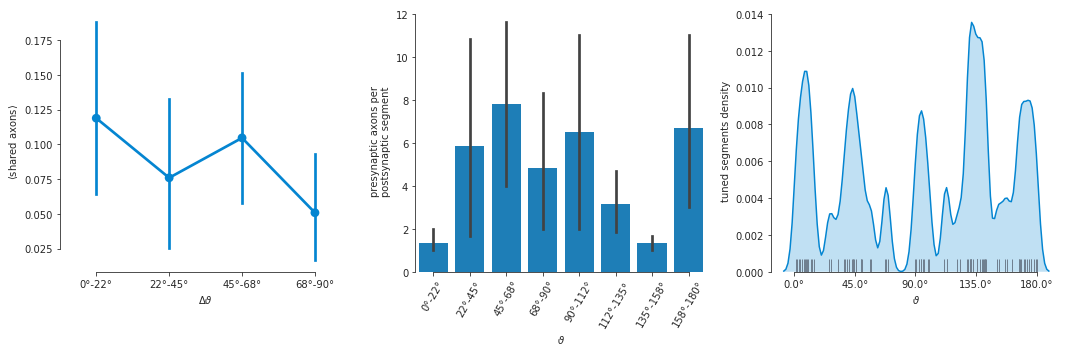

In [31]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
blue = sns.xkcd_rgb['cerulean']                     #####changed only to this connection
sns.pointplot('bdori', 'n_seg_shared', data=df[df.connection == "oblique (>0.75)"], kind='point', ax=ax[0], color=blue)
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)

# sns.distplot(df_segments.ori, ax=ax[1], kde=False, norm_hist=False,
#             hist_kws=dict(color=blue))
sns.barplot('bori', 'presyn', ax=ax[1], data=df_m, orient='vertical', color=blue)

sns.distplot(df_tuned.ori, ax=ax[2], kde=True, rug=True, 
             kde_kws=dict(bw=3, shade=True, color=blue), 
             rug_kws=dict(color='slategray'),
             hist=False)


ax[0].set_ylabel(r'$\langle$shared axons$\rangle$')
ax[0].set_xlabel(r'$\Delta \vartheta$')

xt = np.linspace(0, 180, 5)
for a in ax[1:]:
    a.set_xlabel(r'$\vartheta$')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=60)

ax[2].set_xticks(xt)
ax[2].set_xticklabels(['{}°'.format(t) for t in xt])
ax[1].set_ylabel('presynaptic axons per\npostsynaptic segment')
ax[2].set_ylabel('tuned segments density')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/tuning_statistics.png', dpi=200)
fig.savefig('figures/tuning_statistics.pdf')

# OBLIQUE Heatmap of preferred orientation and number of shared segments

bori_2,33.75,56.25,78.75,101.25,123.75,146.25,168.75
bori_1,,,,,,,
33.75,0.40,0.20,0.000000,0.1,0.250,0.100,0.000000
56.25,0.20,0.20,0.050000,0.0,0.000,0.000,0.200000
78.75,0.00,0.05,0.166667,0.0,0.125,0.125,0.062500
101.25,0.10,0.00,0.000000,0.0,0.000,0.000,0.000000
123.75,0.25,0.00,0.125000,0.0,0.000,0.000,0.000000
146.25,0.10,0.00,0.125000,0.0,0.000,0.000,0.125000
168.75,0.00,0.20,0.062500,0.0,0.000,0.125,0.166667


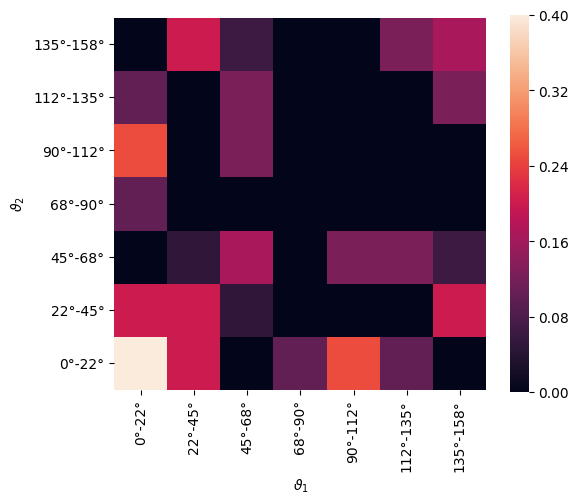

In [32]:
df2 = df[df.connection == 'oblique (>0.75)'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)
g.figure.set_size_inches((6,5))
g.figure.set_dpi(100)
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.invert_yaxis()
g.set_xlabel(r'$\vartheta_1$')
g.set_ylabel(r'$\vartheta_2$')
df2

# ------------SOMA Combined plot------------------------#

In [33]:
compartment_axons = np.load("compartment_axon_groups.npz")
soma_axons = compartment_axons["soma_axons"]

In [34]:
######-------------COULD JUST RESTRICT BY THE SYNAPSE NUMBER HERE ------------############



dict_key = [dict(presyn=c) for c in soma_axons]
segs = (ta3.Synapse * pref_rel.proj(ori='von_pref', postsyn='segment_id') 
            & (ta3.Neurite & dict(neurite_type='axon')).proj(presyn='segment_id') & dict_key)
                
''' output: on a synapse level here


'''

segs

segmentation segmentation id,synapse_id synapse index within the segmentation,scan_idx scan ID,postsyn segment id unique within each Segmentation,presyn segment id unique within each Segmentation,synapse_x (EM voxels),synapse_y (EM voxels),synapse_z (EM voxels),syn_bbox_x1 (EM voxels) - bounding box,syn_bbox_y1 (EM voxels) - bounding box,syn_bbox_z1 (EM voxels) - bounding box,syn_bbox_x2 (EM voxels) - bounding box,syn_bbox_y2 (EM voxels) - bounding box,syn_bbox_z2 (EM voxels) - bounding box,ori preferred directions
1,2251283,2,3813916,26775691,58288,14951,796,58186,14897,793,58401,14994,800,2.90859
1,1949973,2,10914339,14980347,52396,12384,462,52159,12306,453,52565,12512,479,3.13328
1,1994701,2,10914339,7283295,52932,10203,359,52845,10105,350,53015,10295,370,3.13328
1,1996839,2,10914339,19011368,53040,12088,575,52872,11972,558,53150,12252,587,3.13328
1,2042732,2,10914339,19011368,53489,11820,622,53316,11757,613,53598,11884,630,3.13328
1,2043306,2,10914339,19011368,53464,12644,419,53294,12545,410,53607,12770,433,3.13328
1,2090739,2,10914339,3331167,55145,10009,460,55074,9914,448,55251,10148,474,3.13328


In [35]:
#gets the segments and their orientation preference

df_segments = pd.DataFrame(segs.fetch())
df_segments['ori'] = (df_segments['ori'] % np.pi) * rad2deg
df_segments['bori'] = bin_centers[(np.digitize(df_segments['ori'] % np.pi, bin_edges))-1]
df_m = df_segments.groupby(['postsyn','ori','bori'])['presyn'].count().reset_index()

Get tuned neurons

In [36]:
df_tuned = pd.DataFrame(pref_rel.proj(ori='von_pref').fetch())
df_tuned['ori'] = (df_tuned['ori'] % np.pi) * rad2deg

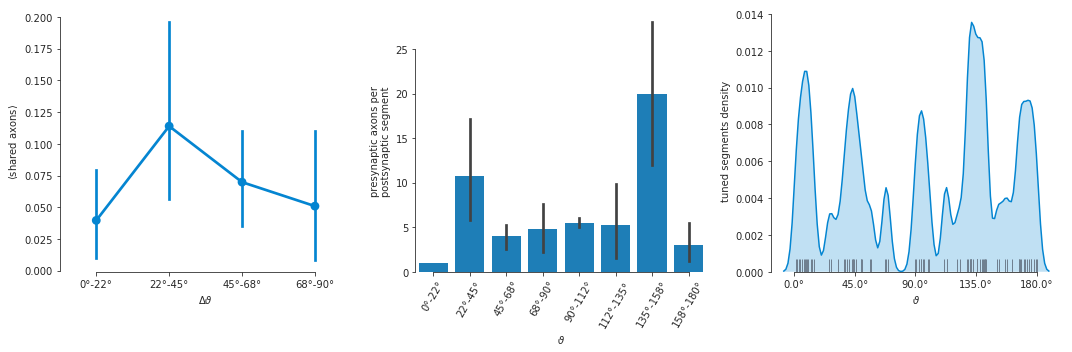

In [37]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
blue = sns.xkcd_rgb['cerulean']                     #####changed only to this connection
sns.pointplot('bdori', 'n_seg_shared', data=df[df.connection == "soma (>0.75)"], kind='point', ax=ax[0], color=blue)
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)

# sns.distplot(df_segments.ori, ax=ax[1], kde=False, norm_hist=False,
#             hist_kws=dict(color=blue))
sns.barplot('bori', 'presyn', ax=ax[1], data=df_m, orient='vertical', color=blue)

sns.distplot(df_tuned.ori, ax=ax[2], kde=True, rug=True, 
             kde_kws=dict(bw=3, shade=True, color=blue), 
             rug_kws=dict(color='slategray'),
             hist=False)


ax[0].set_ylabel(r'$\langle$shared axons$\rangle$')
ax[0].set_xlabel(r'$\Delta \vartheta$')

xt = np.linspace(0, 180, 5)
for a in ax[1:]:
    a.set_xlabel(r'$\vartheta$')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=60)

ax[2].set_xticks(xt)
ax[2].set_xticklabels(['{}°'.format(t) for t in xt])
ax[1].set_ylabel('presynaptic axons per\npostsynaptic segment')
ax[2].set_ylabel('tuned segments density')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/tuning_statistics.png', dpi=200)
fig.savefig('figures/tuning_statistics.pdf')

# SOMA Heatmap of preferred orientation and number of shared segments

bori_2,33.75,56.25,78.75,101.25,123.75,146.25,168.75
bori_1,,,,,,,
33.75,0.10,0.08,0.0500,0.1,0.05,0.300,0.0500
56.25,0.08,0.10,0.0000,0.1,0.00,0.400,0.0500
78.75,0.05,0.00,0.0000,0.0,0.00,0.125,0.0625
101.25,0.10,0.10,0.0000,0.0,0.00,0.000,0.0000
123.75,0.05,0.00,0.0000,0.0,0.00,0.000,0.0000
146.25,0.30,0.40,0.1250,0.0,0.00,0.000,0.3750
168.75,0.05,0.05,0.0625,0.0,0.00,0.375,0.0000


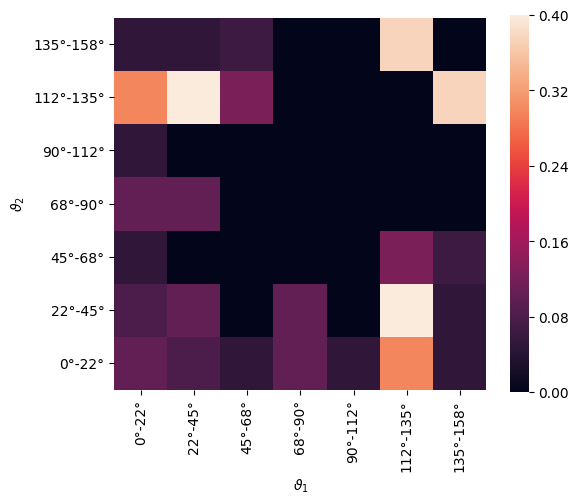

In [38]:
df2 = df[df.connection == 'soma (>0.75)'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)
g.figure.set_size_inches((6,5))
g.figure.set_dpi(100)
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.invert_yaxis()
g.set_xlabel(r'$\vartheta_1$')
g.set_ylabel(r'$\vartheta_2$')
df2

# Receptive fields

# ------------AXON Combined plot------------------------#

In [39]:
compartment_axons = np.load("compartment_axon_groups.npz")
axon_axons = compartment_axons["axon_axons"]

In [40]:
######-------------COULD JUST RESTRICT BY THE SYNAPSE NUMBER HERE ------------############



dict_key = [dict(presyn=c) for c in axon_axons]
segs = (ta3.Synapse * pref_rel.proj(ori='von_pref', postsyn='segment_id') 
            & (ta3.Neurite & dict(neurite_type='axon')).proj(presyn='segment_id') & dict_key)
                
''' output: on a synapse level here


'''

segs

segmentation segmentation id,synapse_id synapse index within the segmentation,scan_idx scan ID,postsyn segment id unique within each Segmentation,presyn segment id unique within each Segmentation,synapse_x (EM voxels),synapse_y (EM voxels),synapse_z (EM voxels),syn_bbox_x1 (EM voxels) - bounding box,syn_bbox_y1 (EM voxels) - bounding box,syn_bbox_z1 (EM voxels) - bounding box,syn_bbox_x2 (EM voxels) - bounding box,syn_bbox_y2 (EM voxels) - bounding box,syn_bbox_z2 (EM voxels) - bounding box,ori preferred directions
1,1761225,2,3813916,33718392,47266,15515,201,47210,15485,200,47310,15539,204,2.90859
1,2007224,2,23410728,83929561,52824,20856,834,52798,20815,831,52855,20901,838,2.10778
1,2010111,2,23410728,52422998,52709,22510,785,52697,22472,782,52719,22553,789,2.10778
1,2010137,2,23410728,117430401,52738,22791,790,52713,22747,785,52760,22848,794,2.10778
1,2011492,2,23410728,52422998,52537,23916,758,52498,23886,753,52573,23943,764,2.10778
1,2011503,2,23410728,117430401,52661,23778,766,52507,23727,761,52694,23855,773,2.10778
1,2012957,2,23410728,52422998,52529,24183,742,52512,24162,741,52553,24204,744,2.10778


In [41]:
#gets the segments and their orientation preference

df_segments = pd.DataFrame(segs.fetch())
df_segments['ori'] = (df_segments['ori'] % np.pi) * rad2deg
df_segments['bori'] = bin_centers[(np.digitize(df_segments['ori'] % np.pi, bin_edges))-1]
df_m = df_segments.groupby(['postsyn','ori','bori'])['presyn'].count().reset_index()

Get tuned neurons

In [42]:
df_tuned = pd.DataFrame(pref_rel.proj(ori='von_pref').fetch())
df_tuned['ori'] = (df_tuned['ori'] % np.pi) * rad2deg

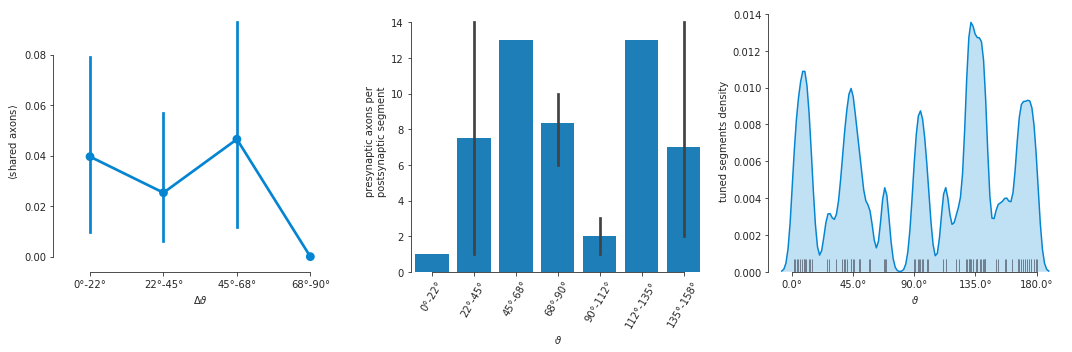

In [43]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
blue = sns.xkcd_rgb['cerulean']                     #####changed only to this connection
sns.pointplot('bdori', 'n_seg_shared', data=df[df.connection == "axon (>0.75)"], kind='point', ax=ax[0], color=blue)
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)

# sns.distplot(df_segments.ori, ax=ax[1], kde=False, norm_hist=False,
#             hist_kws=dict(color=blue))
sns.barplot('bori', 'presyn', ax=ax[1], data=df_m, orient='vertical', color=blue)

sns.distplot(df_tuned.ori, ax=ax[2], kde=True, rug=True, 
             kde_kws=dict(bw=3, shade=True, color=blue), 
             rug_kws=dict(color='slategray'),
             hist=False)


ax[0].set_ylabel(r'$\langle$shared axons$\rangle$')
ax[0].set_xlabel(r'$\Delta \vartheta$')

xt = np.linspace(0, 180, 5)
for a in ax[1:]:
    a.set_xlabel(r'$\vartheta$')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=60)

ax[2].set_xticks(xt)
ax[2].set_xticklabels(['{}°'.format(t) for t in xt])
ax[1].set_ylabel('presynaptic axons per\npostsynaptic segment')
ax[2].set_ylabel('tuned segments density')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/tuning_statistics.png', dpi=200)
fig.savefig('figures/tuning_statistics.pdf')

# AXON Heatmap of preferred orientation and number of shared segments

bori_2,33.75,56.25,78.75,101.25,123.75,146.25,168.75
bori_1,,,,,,,
33.75,0.00,0.00,0.000000,0.0,0.00,0.10,0.050
56.25,0.00,0.00,0.100000,0.0,0.05,0.00,0.000
78.75,0.00,0.10,0.166667,0.0,0.00,0.00,0.125
101.25,0.00,0.00,0.000000,0.0,0.00,0.00,0.000
123.75,0.00,0.05,0.000000,0.0,0.00,0.00,0.000
146.25,0.10,0.00,0.000000,0.0,0.00,0.00,0.250
168.75,0.05,0.00,0.125000,0.0,0.00,0.25,0.000


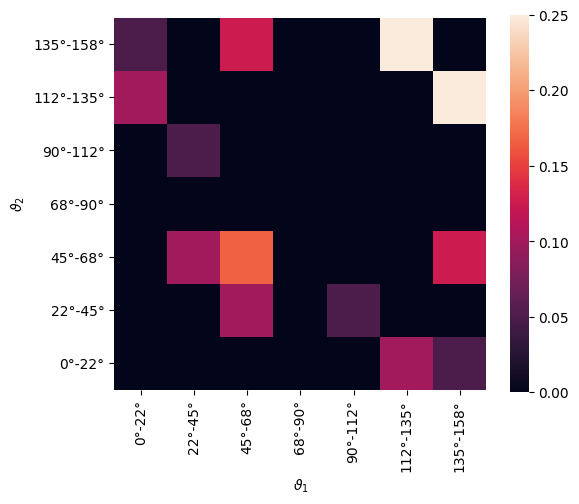

In [44]:
df2 = df[df.connection == 'axon (>0.75)'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)
g.figure.set_size_inches((6,5))
g.figure.set_dpi(100)
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.invert_yaxis()
g.set_xlabel(r'$\vartheta_1$')
g.set_ylabel(r'$\vartheta_2$')
df2

# ------------OTHER Combined plot------------------------#

In [45]:
compartment_axons = np.load("compartment_axon_groups.npz")

other_axons = compartment_axons["other_axons"]
print(other_axons)
print(len(other_axons))

[ 88113152  99229699 108265478 ... 120823802 107175932  71876605]
4605


In [46]:
######-------------COULD JUST RESTRICT BY THE SYNAPSE NUMBER HERE ------------############



dict_key = [dict(presyn=c) for c in other_axons]
segs = (ta3.Synapse * pref_rel.proj(ori='von_pref', postsyn='segment_id') 
            & (ta3.Neurite & dict(neurite_type='axon')).proj(presyn='segment_id') & dict_key)
                
''' output: on a synapse level here


'''

segs

segmentation segmentation id,synapse_id synapse index within the segmentation,scan_idx scan ID,postsyn segment id unique within each Segmentation,presyn segment id unique within each Segmentation,synapse_x (EM voxels),synapse_y (EM voxels),synapse_z (EM voxels),syn_bbox_x1 (EM voxels) - bounding box,syn_bbox_y1 (EM voxels) - bounding box,syn_bbox_z1 (EM voxels) - bounding box,syn_bbox_x2 (EM voxels) - bounding box,syn_bbox_y2 (EM voxels) - bounding box,syn_bbox_z2 (EM voxels) - bounding box,ori preferred directions
1,1270386,2,2589588,79974890,36506,41786,139,36437,41737,131,36582,41852,148,3.02107
1,1271039,2,2589588,123885132,36484,43483,238,36471,43467,236,36500,43500,241,3.02107
1,1309826,2,2589588,90619249,37752,37595,188,37725,37560,185,37777,37623,192,3.02107
1,1312060,2,2589588,109238974,37420,40098,233,37386,40065,230,37455,40137,237,3.02107
1,1312216,2,2589588,95769865,37573,39604,260,37519,39543,256,37617,39658,265,3.02107
1,1395770,2,2589588,64256295,39635,31187,98,39614,31165,98,39664,31208,100,3.02107
1,1396838,2,2589588,71999751,39502,31546,110,39484,31523,109,39532,31570,111,3.02107


In [47]:
#gets the segments and their orientation preference

df_segments = pd.DataFrame(segs.fetch())
df_segments['ori'] = (df_segments['ori'] % np.pi) * rad2deg
df_segments['bori'] = bin_centers[(np.digitize(df_segments['ori'] % np.pi, bin_edges))-1]
df_m = df_segments.groupby(['postsyn','ori','bori'])['presyn'].count().reset_index()

Get tuned neurons

In [48]:
df_tuned = pd.DataFrame(pref_rel.proj(ori='von_pref').fetch())
df_tuned['ori'] = (df_tuned['ori'] % np.pi) * rad2deg

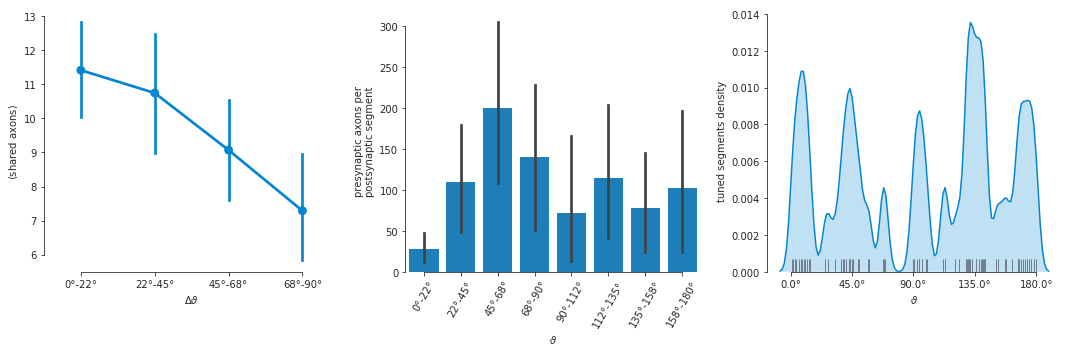

In [49]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
blue = sns.xkcd_rgb['cerulean']                     #####changed only to this connection
sns.pointplot('bdori', 'n_seg_shared', data=df[df.connection == "other"], kind='point', ax=ax[0], color=blue)
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)

# sns.distplot(df_segments.ori, ax=ax[1], kde=False, norm_hist=False,
#             hist_kws=dict(color=blue))
sns.barplot('bori', 'presyn', ax=ax[1], data=df_m, orient='vertical', color=blue)

sns.distplot(df_tuned.ori, ax=ax[2], kde=True, rug=True, 
             kde_kws=dict(bw=3, shade=True, color=blue), 
             rug_kws=dict(color='slategray'),
             hist=False)


ax[0].set_ylabel(r'$\langle$shared axons$\rangle$')
ax[0].set_xlabel(r'$\Delta \vartheta$')

xt = np.linspace(0, 180, 5)
for a in ax[1:]:
    a.set_xlabel(r'$\vartheta$')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=60)

ax[2].set_xticks(xt)
ax[2].set_xticklabels(['{}°'.format(t) for t in xt])
ax[1].set_ylabel('presynaptic axons per\npostsynaptic segment')
ax[2].set_ylabel('tuned segments density')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/tuning_statistics.png', dpi=200)
fig.savefig('figures/tuning_statistics.pdf')

# OTHER Heatmap of preferred orientation and number of shared segments

bori_2,33.75,56.25,78.75,101.25,123.75,146.25,168.75
bori_1,,,,,,,
33.75,9.80,11.16,10.000000,8.300,10.6000,10.600,9.2000
56.25,11.16,10.00,12.250000,8.200,11.2000,11.600,10.7500
78.75,10.00,12.25,10.666667,5.125,8.9375,16.125,11.1875
101.25,8.30,8.20,5.125000,5.000,5.8750,3.250,6.5000
123.75,10.60,11.20,8.937500,5.875,7.0000,8.750,9.8125
146.25,10.60,11.60,16.125000,3.250,8.7500,7.000,11.8750
168.75,9.20,10.75,11.187500,6.500,9.8125,11.875,4.0000


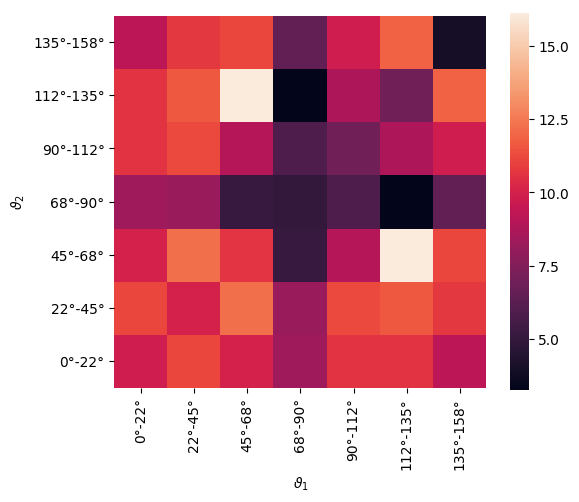

In [50]:
df2 = df[df.connection == 'other'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)
g.figure.set_size_inches((6,5))
g.figure.set_dpi(100)
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.invert_yaxis()
g.set_xlabel(r'$\vartheta_1$')
g.set_ylabel(r'$\vartheta_2$')
df2

Get significant receptive fields

# Receptive fields

In [51]:
attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

cbin_edges = np.linspace(-.7, .7, 6)
cbin_centers = np.hstack((np.nan, np.round((cbin_edges[1:] + cbin_edges[:-1])/2, decimals=2), np.nan))
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(cbin_edges[:-1], cbin_edges[1:])]

In [52]:
rf_scores = dj.U('segment_id').aggr(nda.RFScore(), mscore='max(score)') & good_rf

In [53]:
# shi = (dj.U(*attrs) & PostSynapticPairAxonalInput.proj(n_seg_shared='n_seg_shared/n_seg_union', connection='"non-perisomatic"', 
#                                                        segment_a = 'segment_id')) + \
#       (dj.U(*attrs) & PostSynapticPairAxonalInput.proj(n_seg_shared='n_seg_shared/n_seg_union', connection='"non-perisomatic"', 
#                                                        segment_a='segment_b', segment_b='segment_id'))# + \
# crel = shi * RFCorrelation.Pair().proj('rf_corr_coef', segment_a='segment_id', segment_b='other_seg') * \
#     pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref') * \
#     rf_scores.proj(score_a='mscore', segment_a='segment_id') * rf_scores.proj(score_b='mscore', segment_b='segment_id')

Get all *tuned* neurons with *well scoring RFs* and get their pairwise shared input. 

In [54]:
#creating same large table that could replace with groups
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id'))



# + \
#       (dj.U(*attrs) & SharedContactPair.proj('segment_a', 'segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) + \
#       (dj.U(*attrs) & SharedContactPair.proj(segment_b='segment_a', segment_a='segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) 

crel = shi * RFCorrelation.Pair().proj('rf_corr_coef', segment_a='segment_id', segment_b='other_seg') * \
    pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref') * \
    rf_scores.proj(segment_a='segment_id') * rf_scores.proj(segment_b='segment_id')

In [55]:
cdf = pd.DataFrame(crel.fetch())

In [56]:
cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], cbin_edges))]
cdf['n_seg_shared'] = np.array(cdf['n_seg_shared']).astype(float)
cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)



In [57]:
cdf['dori'] = np.abs(circ.cdiff(2 * cdf['ori_1'], 2 * cdf['ori_2'])/2) 
cdf['bdori'] = bin_centers[(np.digitize(np.abs(circ.cdiff(2 * cdf['ori_1'], 2 * cdf['ori_2'])/2), bin_edges))]


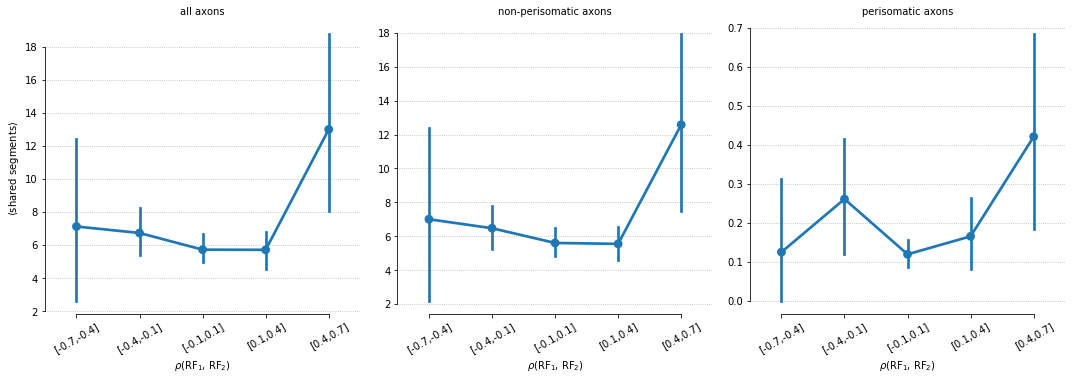

In [58]:
g = sns.catplot('bcorr', 'n_seg_shared', data=cdf, col='connection', kind='point', legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\rho$(RF$_1$, RF$_2$)', y_var=r'$\langle$shared segments$\rangle$')

for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(cbin_labels, rotation=30)
sns.despine(trim=True)
g.set_titles('{col_name} axons')

g.fig.savefig('figures/average_shared_input_vs_correlation.png', dpi=200)
g.fig.savefig('figures/average_shared_input_vs_correlation.pdf')

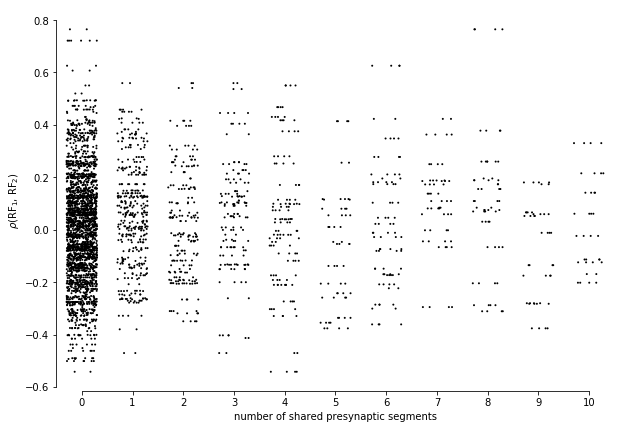

In [59]:
g = sns.stripplot( 'n_seg_shared', 'rf_corr_coef', data=cdf[cdf.n_seg_shared < 11], jitter=0.3, s=2, color='k')
g.set_xlabel(r'number of shared presynaptic segments')
g.set_xticklabels([int(e) for e in g.get_xticks()])
g.set_ylabel(r'$\rho$(RF$_1$, RF$_2$)')
sns.despine(trim=True)
g.figure.set_size_inches((10,7))
g.figure.savefig('figures/shared_input_stripplot.png', dpi=200)
g.figure.savefig('figures/shared_input_stripplot.pdf')

In [60]:
neg90 = cdf[(cdf.dori > 70/180*np.pi) & (cdf.rf_corr_coef > .40)]
neg90

,segment_a,connection,segment_b,n_seg_shared,segmentation,dummy,scan_idx,rf_corr_coef,ori_1,ori_2,bcorr,dori,bdori
879,81578447,perisomatic,110137680,0.0,1,2,3,0.493886,3.27333,1.63936,0.56,1.507623,101.25
880,81578447,all,110137680,0.0,1,2,3,0.493886,3.27333,1.63936,0.56,1.507623,101.25
881,81578447,non-perisomatic,110137680,0.0,1,2,3,0.493886,3.27333,1.63936,0.56,1.507623,101.25
1347,53349510,all,107860456,1.0,1,3,3,0.458215,1.56219,3.16470,0.56,1.539083,101.25
1348,53349510,non-perisomatic,107860456,1.0,1,3,3,0.458215,1.56219,3.16470,0.56,1.539083,101.25
1349,53349510,perisomatic,107860456,0.0,1,3,3,0.458215,1.56219,3.16470,0.56,1.539083,101.25
1380,53349510,all,99210911,0.0,1,3,3,0.492442,1.56219,6.18547,0.56,1.481687,101.25
1381,53349510,non-perisomatic,99210911,0.0,1,3,3,0.492442,1.56219,6.18547,0.56,1.481687,101.25
1382,53349510,perisomatic,99210911,0.0,1,3,3,0.492442,1.56219,6.18547,0.56,1.481687,101.25
1428,53349510,all,48234238,3.0,1,3,4,0.445472,1.56219,6.13613,0.56,1.432347,101.25


In [61]:
neg90 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (53349510, 39500491)').fetch('rf')]
neg0 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (107860456, 39500491)').fetch('rf')]
pos0 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (83286327, 5386310)').fetch('rf')]
pos90 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (53349510, 99210911)').fetch('rf')]

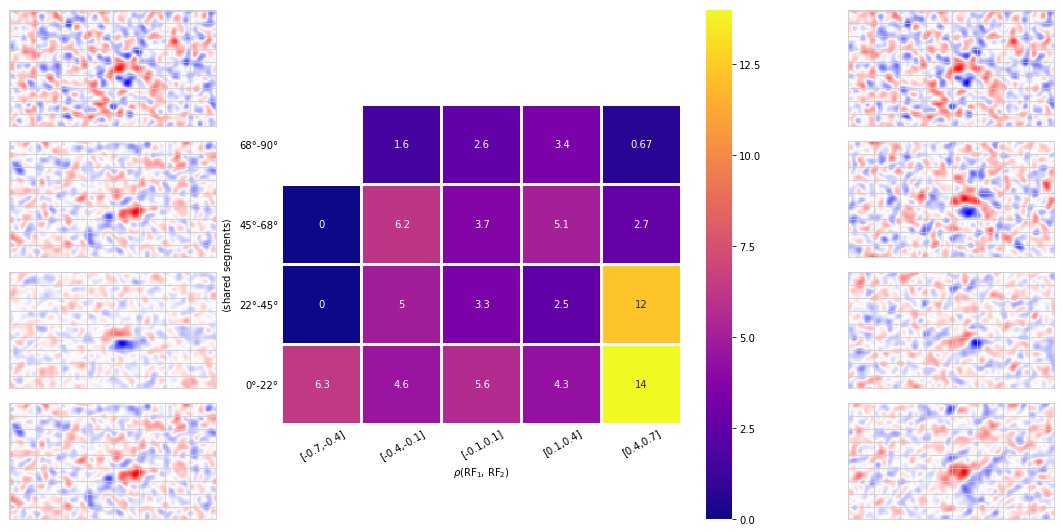

In [62]:
from itertools import chain
gs = plt.GridSpec(4, 4)
fig = plt.figure(figsize=(15,7.5))
ax_heat = fig.add_subplot(gs[:,1:3])
with sns.axes_style('whitegrid'):
    ax_tl = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])]
    ax_tr = [fig.add_subplot(gs[0,-1]), fig.add_subplot(gs[1,-1])]
    ax_br = [fig.add_subplot(gs[-2,-1]), fig.add_subplot(gs[-1,-1])]
    ax_bl = [fig.add_subplot(gs[-2,0]), fig.add_subplot(gs[-1,0])]

for tl, rf in chain(zip(ax_tl, neg90), zip(ax_bl, neg0), zip(ax_br, pos0),  zip(ax_tr, pos90)):
    rf -= rf.mean()
    v = np.abs(rf).max()
#     tl.contour(rf, cmap='bwr', levels=np.linspace(-v,v,7))
    tl.matshow(rf, cmap='bwr', vmin=-v, vmax=v)
    tl.set_xticklabels([])
    tl.set_yticklabels([])
    tl.tick_params(axis='both', length=0, width=0)

    
    
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].mean().reset_index()

df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2, ax=ax_heat)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
g.set_xticklabels(cbin_labels, rotation=30)
g.invert_yaxis()
g.tick_params(length=0)
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

fig.subplots_adjust(wspace=.01, hspace=.01)
fig.tight_layout()
g.figure.savefig('figures/corr_vs_shared_input_heatmap.png', dpi=200)
g.figure.savefig('figures/corr_vs_shared_input_heatmap.pdf')


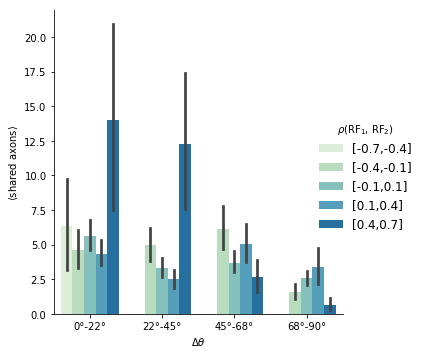

In [63]:
g = sns.catplot('bdori', 'n_seg_shared', hue='bcorr', kind='bar', palette=sns.color_palette('GnBu', n_colors=5), data=cdf, legend=False)
g.add_legend(prop={'size':12})
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared axons$\rangle$')
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
new_labels = cbin_labels
g._legend.set_title(r'$\rho$(RF$_1$, RF$_2$)')
for t, l in zip(g._legend.texts, new_labels): 
    t.set_text(l)

sns.despine()
g.fig.savefig('figures/corr_vs_shared_input_bar.png', dpi=200)
g.fig.savefig('figures/corr_vs_shared_input_bar.pdf')